# Машинное обучение, ШАД, Минск
## Лабораторная работа 3. Линейные модели классификации и регрессии, валидация моделей.


**Правила:**

* Выполненную работу нужно отправить в соответствующее задание в личном кабинете
* Дедлайн **14 октября 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Для сдачи задания нужно загрузить **ноутбук в формате `ipynb`** в ЛМС.
* Выполнять задание необходимо полностью самостоятельно.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Присылайте понятный и читаемый код. Если код не будет понятен проверяющему, оценка может быть снижена.
* Код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * прикрепив ее в ЛМС в форматах `pdf`, `png` или `jpg` *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image`;
  * в виде $\LaTeX$ в markdown-ячейках или в отдельном `pdf`-файле.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Максимальное количество баллов за задание: 5 баллов.**

----

### Задание.

Реализуйте логистическую регрессию с $L_2$ регуляризацией для поиска оценки параметров с помощью стохастического mini-batch градиентного спуска (SGD).

In [3]:
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.base import ClassifierMixin
from sklearn.metrics import f1_score

In [14]:
class LogisticRegression(ClassifierMixin):
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:

    :param alpha: параметр регуляризации.
                  Если равно 0, то регуляризация не происходит.
    :param lr: константа, на которую домножаем градиент при обучении
    :param max_iter: ограничение на кол-во итераций
    :param fit_intercept: указывает, следует ли добавить константу в признаки
    '''

    def __init__(self, alpha=0.1, learning_rate=0.5, max_iter=1e2,
                 fit_intercept=True):
        '''Создает модель и инициализирует параметры.'''

        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept

        self.batch_size = 64
        self.tol = 1e-4
        self.classes_ = None

        self.weights = [0]
        self.coef_ = None
        self.intercept_ = 0


    @staticmethod
    def _sigmoid(x):
        '''
        Возвращает сигмоиду от х
        '''
        return expit(x)

    def _add_intercept(self, X):
        '''
        Добавляем свободный коэффициент к нашей модели.
        Это происходит путем добавления вектора из 1 к исходной матрице.

        :param X: исходная матрица признаков
        :return: матрица X с добавленным свободным коэффициентов
        '''

        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1.)
        X_copy[:, :-1] = X

        return X_copy

    def fit(self, X, Y):
        '''
        Обучает модель логистической регресии с помощью SGD,
        пока не выполнится self.max_iter итераций.

        :param X: матрица признаков
        :param Y: истинные метки
        '''

        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        n, m = X_copy.shape
        X, Y = np.array(X_copy), np.array(Y)
        # self.weights состоит из коэффициентов модели и свободного члена
        self.weights = np.random.normal(size=m)
        self.classes_ = np.unique(Y) # количество уникальных классов
        for iter in np.arange(self.max_iter):

            indexes = np.random.choice(n, size=self.batch_size, replace=False)
            X_batch, y_batch = X[indexes], Y[indexes]
            predictions = self._sigmoid(X_batch @ self.weights)
            grad_weights = self.learning_rate * self.calculate_derivative_weights(X_batch, y_batch, predictions)
            if self.norm_weights(grad_weights):
                break
            else:
                self.weights -= grad_weights
                self.weights = np.clip(self.weights, -1e10, 1e10) #  ограничения на веса
            print(grad_weights[0])

        if self.fit_intercept:
            self.coef_ = self.weights[:-1]  # коэффициенты модели
            self.intercept_ = np.array([self.weights[-1]])   # свободный коэффициент
        else:
            self.coef_ = self.weights # нет свободного коэффициента
        return self

    def predict(self, X):
        '''
        Применяет обученную модель к данным
        и возвращает точечное предсказание (оценку класса).

        :param X: матрица признаков
        :return: предсказание с размерностью (n_test, )
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        threshold = 0.5

        predictions = np.array([int(threshold < pred) for pred in self._sigmoid(X_copy @ self.weights)])
        return predictions

    def predict_proba(self, X):
        '''
        Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1.

        :param X: матрица признаков
        :return: вероятности предсказания с размерностью (n_test, 2)
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.weights.shape[0]

        sigmoid_vals = self._sigmoid(X_copy @ self.weights)
        prob_predictions = np.column_stack([1- sigmoid_vals, sigmoid_vals])

        return prob_predictions

    def calculate_derivative_weights(self, X, y, predictions):
        '''
        Считает градиент функции потерь по предсказаниям модели
        '''
        return X.T @ (predictions - y) / self.batch_size + self.alpha * self.weights

    def norm_weights(self, grad):
        '''
        Считатет норму разности весов на соседних шагах градиентного спуска
        return: проверяет меньше ли норма порогового значения
        '''
        return np.linalg.norm(grad) < self.tol

    def score(self, X, y):
        '''
        Вычисляет и возвращает значение F1-меры для предсказанной модели.
        Параметры:
        ----------
        X : array-like, shape (n_samples, n_features)
        y : array-like, shape (n_samples,) - истинные метки классов
        Возвращает:
        ----------
        float - Значение F1-меры
        '''
        return f1_score(y, self.predict(X))

    def get_params(self, deep=True):
        '''
        Возвращает параметры модели
        '''
        return {"alpha": self.alpha,
                "learning_rate": self.learning_rate,
                "max_iter": self.max_iter,
                "fit_intercept": self.fit_intercept}

Рассмотрим игрушечный датасет на $30$ признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для бинарной классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

[':Attribute Information:',
 '    - radius (mean of distances from center to points on the perimeter)',
 '    - texture (standard deviation of gray-scale values)',
 '    - perimeter',
 '    - area',
 '    - smoothness (local variation in radius lengths)',
 '    - compactness (perimeter^2 / area - 1.0)',
 '    - concavity (severity of concave portions of the contour)',
 '    - concave points (number of concave portions of the contour)',
 '    - symmetry',
 '    - fractal dimension ("coastline approximation" - 1)',
 '',
 '    The mean, standard error, and "worst" or largest (mean of the three',
 '    worst/largest values) of these features were computed for each image,',
 '    resulting in 30 features.  For instance, field 0 is Mean Radius, field',
 '    10 is Radius SE, field 20 is Worst Radius.',
 '',
 '    - class:',
 '            - WDBC-Malignant',
 '            - WDBC-Benign']

Разделим нашу выборку на обучающую и тестовую:

In [9]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь обучите модель логистической регрессии.

In [15]:
logistic_redression = LogisticRegression()
logistic_redression.fit(X_train_scaled, Y_train)

0.2769758384214736
0.09914374929158705
0.07949339665652379
0.04426517005768639
0.04569982919707421
0.002361710153071673
0.0005808768369088696
0.007799861956812839
0.005915931134552441
-0.021088526785678074
-0.003483543429184119
0.00011551058151747229
0.0008650602687679011
0.0009371285414079764
-0.0009853421918388332
-0.008940261625987862
-0.009284518965160124
0.00634169588217974
-0.011329123670202192
-0.018249619211575724
-0.009640389778945605
-0.002987621599590047
-0.006915540021844474
-0.0005832309675643452
0.004124246944479132
-0.007241666296203785
-0.0022889110956372284
-0.0011699186256148263
0.000513523704087606
-0.007512559472312788
0.007917198597866035
0.005919864917887874
-0.004164368193680282
0.010022879104411377
-0.0025590244369623257
-0.004696638175492155
-0.0026357042607450254
-0.009356935388005888
-0.003721246242227442
0.009118680906453173
-0.005596615935497972
0.00307405372643268
-0.00011545350791158926
-0.001448470445223369
-0.006325565704638705
-0.0012059567107349217
-0

На занятии обсуждали, что в нашей постановке задачи при сравнении выиграет модель с меньшим FN, ведь каждая не обнаруженная опухоль может стоить человеческой жизни. Чем меньше ложно отрицательных срабатываний, тем выше Recall модели, а значит разумно взять Recall в качестве целевой метрики.

Построить модель с Recall = 1 довольно просто (Как?), но в ней не будет большого смысла, т.к., например, для нашей задачи отправление на доп. обследование может стоить дополнительных средств и времени специалистов, поэтому хотелось, чтобы наша модель имела неплохую точность. Какую метрику можно использовать, чтобы учесть и точность, и полноту?

**Ответ**:
<p>Чтобы $Recall = \frac{TP}{TP+FN}$ был равен 1 нужно, чтобы $FN=0$, а для этого модель должна всегда выдавать положительный ответ, но при этом будет большое количество $FP$.
Чтобы учесть и точность, и полноту можно использовать $F1=2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$ либо $ROC\_AUC$.


Выберите и посчитайте целевые метрики для нашей задачи.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
prediction_class = logistic_redression.predict(X_test_scaled)
predict_prob = logistic_redression.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print(f"F1_score: {f1_score(Y_test, prediction_class)}\nROC_AUC: {roc_auc_score(Y_test, predict_prob)}")

F1_score: 0.993006993006993
ROC_AUC: 0.9983622666229938


Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Сделайте выводы.

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [ ]:
logs_lr = dict()
for learn_rate in tqdm(lrs, desc="Processing learning rates"):
    lr = LogisticRegression(lr=learn_rate)
    lr.fit(X_train_scaled, Y_train)
    preds = lr.predict(X_test_scaled)
    logs_lr[learn_rate] = f1_score(Y_test, preds)

Processing learning rates: 100%|██████████| 13/13 [00:25<00:00,  1.99s/it]


In [ ]:
logs_lr

{1e-05: 0.6616541353383458,
 0.0001: 0.7285714285714285,
 0.001: 0.9117647058823529,
 0.01: 0.9859154929577465,
 0.1: 0.9714285714285714,
 0.2: 0.9640287769784173,
 0.3: 0.9565217391304348,
 0.5: 0.948905109489051,
 0.7: 0.948905109489051,
 1: 0.948905109489051,
 2: 0.948905109489051,
 5: 0.948905109489051,
 10: 0.9640287769784173}

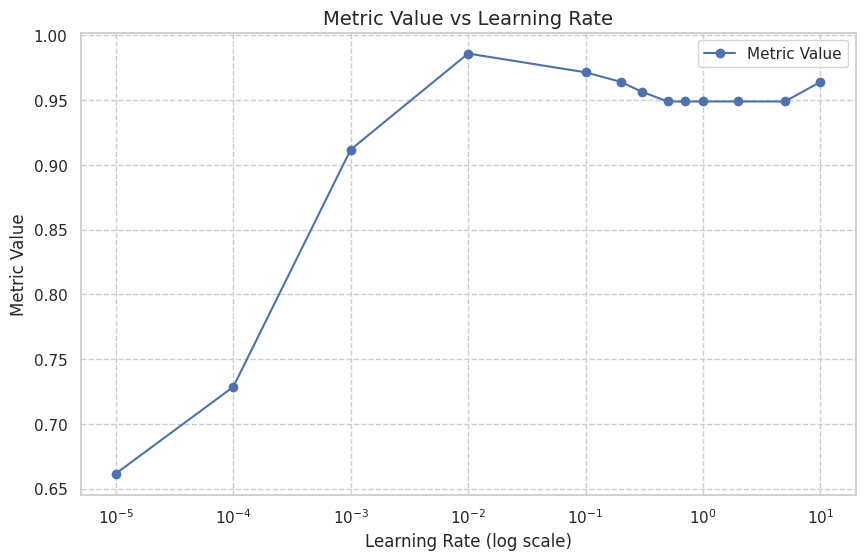

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(logs_lr.keys(), logs_lr.values(), marker='o', color='b', label="Metric Value")
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.xlabel("Learning Rate (log scale)", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.title("Metric Value vs Learning Rate", fontsize=14)
plt.grid(ls="--")
plt.legend()
plt.show()

**Выводы**: При очень маленьком $learning\ rate < 10^{-3}$ значение метрики очень мало, при средних значениях $10^{-3} \leqslant learning\ rate < 10^{-1}$ модель хорошо сходится и показывает наилучший результат, а при  $learning\ rate \geqslant 10^{-1}$ модель колеблется, что показывает, что слишком высокие значения $learning\ rate$ могут привести к ухудшению модели, поскольку она начинает "перепрыгивать" оптимальные решения, что является признаком нестабильного обучения.

Рассмотрите несколько моделей, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на качество, сделайте выводы. Под качеством подразумевается значение какой-либо выбранной вами метрики качества классификации.

In [ ]:
alpha_values = [1e-5, 1e-4, 1e-3, 1e-2, 0., 0.1, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [ ]:
logs_alpha = dict()
for alpha in tqdm(alpha_values, desc="Processing alpha"):
    lr = LogisticRegression(alpha=alpha)
    lr.fit(X_train_scaled, Y_train)
    preds = lr.predict(X_test_scaled)
    logs_alpha[alpha] = f1_score(Y_test, preds)

Processing alpha: 100%|██████████| 13/13 [00:00<00:00, 13.02it/s]


In [ ]:
logs_alpha

{1e-05: 0.9859154929577465,
 0.0001: 0.9790209790209791,
 0.001: 0.9790209790209791,
 0.01: 0.9859154929577465,
 0.0: 0.9859154929577465,
 0.1: 0.993006993006993,
 0.3: 0.9859154929577465,
 0.5: 0.9787234042553191,
 0.7: 0.9859154929577465,
 1: 0.9859154929577465,
 2: 0.971830985915493,
 5: 0.3609022556390977,
 10: 0.26356589147286824}

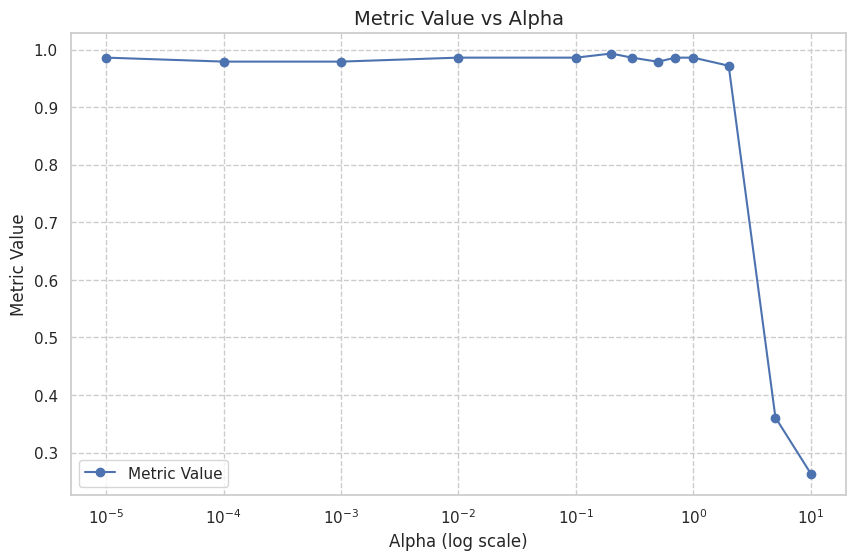

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(logs_lr.keys(), logs_alpha.values(), marker='o', color='b', label="Metric Value")
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.xlabel("Alpha (log scale)", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.title("Metric Value vs Alpha", fontsize=14)
plt.grid(ls="--")
plt.legend()
plt.show()

**Выводы**: При очень маленьком $alpha < 10^{-2}$ значение метрики мало, так как модель недостаточно обучается из-за слишком низкой скорости обучения, при средних значениях $10^{-2} \leqslant alpha < 0.7 $ модель хорошо сходится и показывает наилучший результат, при  $0.7 \leqslant alpha < 5$ метрика немного снижается, но все еще остается на достаточно высоком уровне, а при $alpha \geqslant 5$ метрика падает до 0.0, что говорит о том, что модель совершенно не обучается и начинает "перепрыгивать" оптимальные параметры, что приводит к плохим в предсказаниям.

Выберите наилучшее значение коэффициента регуляризации с помощью кросс-валидации для двух подходов &mdash; `KFold` и `ShuffleSplit`. Используйте пять фолдов/разбиений.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [ ]:
cross_val_kfold = dict()
cross_val_ss = dict()
for alpha in tqdm(alpha_values, desc="Cross validation alpha"):
    cross_val_kfold[alpha] = cross_val_score(LogisticRegression(alpha=alpha), X_train_scaled, Y_train, cv=kfold).mean()
    cross_val_ss[alpha] = cross_val_score(LogisticRegression(alpha=alpha), X_train_scaled, Y_train, cv=ss).mean()

Cross validation alpha: 100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


In [ ]:
cross_val_kfold

{1e-05: 0.9807155308354829,
 0.0001: 0.9813625342342889,
 0.001: 0.9804276099593267,
 0.01: 0.9790670519388065,
 0.0: 0.9806959516360081,
 0.1: 0.979291839413882,
 0.3: 0.968956493579971,
 0.5: 0.9668742539278558,
 0.7: 0.9585948292619711,
 1: 0.9563916466508612,
 2: 0.9534466681836953,
 5: 0.8250172976789166,
 10: 0.45144589879571606}

In [ ]:
cross_val_ss

{1e-05: 0.9753360703413201,
 0.0001: 0.9752959826376418,
 0.001: 0.9771370329247698,
 0.01: 0.9788437333040367,
 0.0: 0.9805268634332445,
 0.1: 0.9788174617238428,
 0.3: 0.9699303265092739,
 0.5: 0.9679092112918782,
 0.7: 0.9623981131945734,
 1: 0.9679453018996569,
 2: 0.9620199446520232,
 5: 0.396938231350323,
 10: 0.6731835202920247}

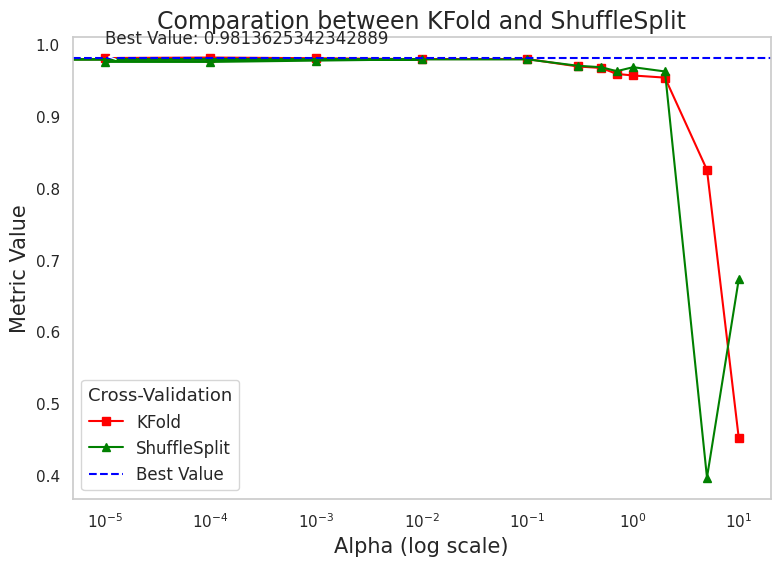

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(cross_val_ss.keys(), cross_val_kfold.values(), label='KFold', color='red', marker='s',)
plt.plot(cross_val_ss.keys(), cross_val_ss.values(), label='ShuffleSplit', color='green', marker='^',)

best_value = max(max(cross_val_kfold.values()), max(cross_val_ss.values()))
plt.axhline(y=best_value, color='blue', linestyle='--', label='Best Value')

best_alpha = 1e-05
plt.annotate(f'Best Value: {best_value}',
             xy=(best_alpha, best_value),
             xytext=(best_alpha, best_value + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Comparation between KFold and ShuffleSplit', fontsize=17)
plt.xscale('log')
plt.xlabel('Alpha (log scale)', fontsize=15)
plt.ylabel('Metric Value', fontsize=15)

plt.legend(title='Cross-Validation', title_fontsize=13, fontsize=12, loc='lower left')

plt.grid()
plt.show()

Для выбранного значения коэффициента регуляризации оцените дисперсию усредненного значения метрики качества на тестовых батчах. Для этого выполните кросс-валидацию достаточно много раз (не менее 100) и посчитайте выборочную дисперсию. Обратите внимание, что для стратегии `KFold` нужно на каждой итерации перемешивать данные, для этого можно указать `shuffle=True`.

Сравните эти две стратегии кросс-валидации. Какие их преимущества и недостатки?

In [ ]:
logs_kfold = []
logs_ss = []
alpha = 0.5
n_iterations = 100
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for iter in tqdm(range(n_iterations), desc='Cross Validation'):
    logs_kfold.append(cross_val_score(LogisticRegression(alpha=alpha), X_train_scaled, Y_train, cv=kfold).mean())
    logs_ss.append(cross_val_score(LogisticRegression(alpha=alpha), X_train_scaled, Y_train, cv=ss).mean())


Cross Validation: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


In [ ]:
print(f"Выборочная дисперсия:\n\
KFold: {np.var(logs_kfold, ddof=1)}\n\
ShuffleSplit: {np.var(logs_ss, ddof=1)}")

Выборочная дисперсия:
KFold: 1.9406991015509635e-05
ShuffleSplit: 9.626806982548692e-06


**Вывод:**
### KFold Cross-Validation


KFold разделяет данные на 𝑘 равных частей (или "фолдов"). Модель обучается на 𝑘−1 фолдах и тестируется на оставшемся фолде.

Преимущества:
* Стабильные оценки
* Баланс между тестированием и обучением

Недостатки:
* Затратен по времени
* Могут оказаться неудачные фиксированные разбиения

### ShuffleSplit Cross-Validation


ShuffleSplit случайным образом перемешивает и делит данные на обучающие и тестовые выборки на каждой итерации. При этом не все данные обязательно используются, как в KFold.

Преимущества:
* Гибкость
* Перемешивание данных
* Эффективность

Недостатки:
* Повторяющееся использование данных:
* Меньшая стабильность
* Требует большего количества итераций